# Model Training
Objective:
The goal of this notebook is to train predictive models that identify customers likely to close their credit card accounts (AttritionFlag) using the processed and feature-engineered dataset.

Dataset:
- Processed datasets: `train.csv` and `test.csv`

- Features include demographic, transaction, card type, and engineered variables.

- Categorical variables are already handled in the data cleaning stage.

Workflow – Model Training:
1. Load Data
- Load `train.csv` and `test.csv`
- Separate features (`X`) and target (`y`)

2. Handle Class Imbalance
- Apply SMOTE on the training set to balance the minority class.

3. Train Classification Models
- Train at least two models:
  - Logistic Regression (baseline linear model)
  - XGBoost (gradient boosting model to capture non-linearities and interactions)
- Perform hyperparameter tuning and cross-validation to optimize each model.

Next Steps:
- The trained models will be saved and later evaluated in a separate notebook using metrics such as accuracy, precision, recall, F1-score, ROC-AUC, and confusion matrix.

In [1]:
import pandas as pd

# Paths to the saved CSVs
train_path = r'..\..\data\processed\train.csv'
test_path  = r'..\..\data\processed\test.csv'

# Load the CSVs
train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

# Split into features and target
X_train = train_df.drop(columns=['AttritionFlag'])
y_train = train_df['AttritionFlag']

X_test  = test_df.drop(columns=['AttritionFlag'])
y_test  = test_df['AttritionFlag']

# Optional: check shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (80000, 88)
y_train shape: (80000,)
X_test shape: (20000, 88)
y_test shape: (20000,)


## 1. Handling Class Imbalance

In [2]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to training data
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Check the new class distribution
print("Before SMOTE:")
print(y_train.value_counts())
print("\nAfter SMOTE:")
print(y_train_res.value_counts())

# Optional: check shapes
print("\nX_train_res shape:", X_train_res.shape)
print("y_train_res shape:", y_train_res.shape)

Before SMOTE:
AttritionFlag
0    76032
1     3968
Name: count, dtype: int64

After SMOTE:
AttritionFlag
0    76032
1    76032
Name: count, dtype: int64

X_train_res shape: (152064, 88)
y_train_res shape: (152064,)


## 2. Logistic Regression Training

In [4]:
from sklearn.preprocessing import StandardScaler

# Fit scaler on training data and transform both training and test
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from tqdm import tqdm
import numpy as np


# Define Logistic Regression
lr = LogisticRegression(solver='lbfgs', max_iter=2000, random_state=42, class_weight='balanced')

# Hyperparameter candidates
param_grid = {'C': [0.1, 1, 10]}

# Stratified K-Fold
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Store results
results = []

# Total number of fits
total_fits = len(param_grid['C']) * cv.get_n_splits()
pbar = tqdm(total=total_fits, desc="GridSearchCV Progress")

# Loop through hyperparameters
for C_val in param_grid['C']:
    lr.set_params(C=C_val)
    # Evaluate with cross-validation using scaled features
    scores = cross_val_score(lr, X_train_res_scaled, y_train_res, cv=cv, scoring='roc_auc', n_jobs=-1)
    results.append({
        'C': C_val,
        'mean_cv_roc_auc': np.mean(scores)
    })
    pbar.update(cv.get_n_splits())  # Update progress bar for each fold set

pbar.close()

# Find best hyperparameter
best_result = max(results, key=lambda x: x['mean_cv_roc_auc'])
best_lr = LogisticRegression(
    C=best_result['C'], solver='lbfgs', max_iter=2000,
    random_state=42, class_weight='balanced'
)
best_lr.fit(X_train_res_scaled, y_train_res)

print("Best Hyperparameters:", best_result)
print("Best CV ROC-AUC:", best_result['mean_cv_roc_auc'])


GridSearchCV Progress:   0%|                                                                     | 0/9 [01:20<?, ?it/s]

GridSearchCV Progress: 100%|█████████████████████████████████████████████████████████████| 9/9 [00:13<00:00,  1.52s/it]


Best Hyperparameters: {'C': 0.1, 'mean_cv_roc_auc': np.float64(0.969252097867352)}
Best CV ROC-AUC: 0.969252097867352


In [6]:
from sklearn.linear_model import LogisticRegression

best_lr = LogisticRegression(C=1, solver='lbfgs', max_iter=2000, random_state=42)
best_lr.fit(X_train_res_scaled, y_train_res)


LogisticRegression(C=1, max_iter=2000, random_state=42)

In [7]:
# Predicted probabilities (for ROC-AUC)
y_pred_prob = best_lr.predict_proba(X_test_scaled)[:, 1]

# Predicted class labels
y_pred = best_lr.predict(X_test_scaled)

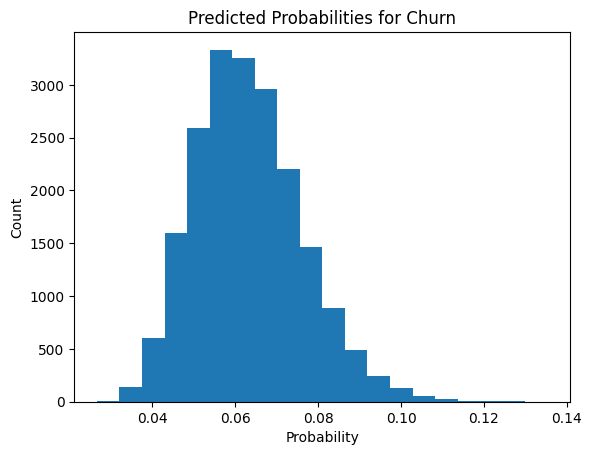

In [8]:
import matplotlib.pyplot as plt

plt.hist(y_pred_prob, bins=20)
plt.title("Predicted Probabilities for Churn")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.show()

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_prob))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

Accuracy: 0.9504
Precision: 0.0
Recall: 0.0
F1-score: 0.0
ROC-AUC: 0.5087563937425329
Confusion Matrix:
 [[19008     0]
 [  992     0]]


D:\Projects\Github Repo\Churn-Prediction-for-Credit-Card-Holders-Using-Predictive-Analytics\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 3. Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from tqdm import tqdm
import numpy as np

# ----------------------
# Define Random Forest
# ----------------------
rf = RandomForestClassifier(
    n_estimators=200,        # number of trees
    random_state=42,
    class_weight='balanced', # handle imbalanced training data
    n_jobs=-1
)

# ----------------------
# Hyperparameter candidates
# ----------------------
param_grid = {
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10]
}

# Stratified K-Fold
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Store results
results = []

# Total number of fits for progress bar
total_fits = len(param_grid['max_depth']) * len(param_grid['min_samples_split']) * cv.get_n_splits()
pbar = tqdm(total=total_fits, desc="Random Forest GridSearchCV")

# ----------------------
# Loop through hyperparameters
# ----------------------
for depth in param_grid['max_depth']:
    for min_split in param_grid['min_samples_split']:
        rf.set_params(max_depth=depth, min_samples_split=min_split)
        scores = cross_val_score(rf, X_train_res, y_train_res, cv=cv, scoring='roc_auc', n_jobs=-1)
        results.append({
            'max_depth': depth,
            'min_samples_split': min_split,
            'mean_cv_roc_auc': np.mean(scores)
        })
        pbar.update(cv.get_n_splits())

pbar.close()

# ----------------------
# Find best hyperparameters
# ----------------------
best_result = max(results, key=lambda x: x['mean_cv_roc_auc'])
best_rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=best_result['max_depth'],
    min_samples_split=best_result['min_samples_split'],
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
best_rf.fit(X_train_res, y_train_res)

print("Best Hyperparameters:", best_result)
print("Best CV ROC-AUC:", best_result['mean_cv_roc_auc'])

Random Forest GridSearchCV: 100%|██████████████████████████████████████████████████████| 27/27 [25:58<00:00, 57.74s/it]


Best Hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'mean_cv_roc_auc': np.float64(0.9924860336957072)}
Best CV ROC-AUC: 0.9924860336957072


In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Predict class labels
y_pred = best_rf.predict(X_test)

# Predict probabilities (for ROC-AUC)
y_pred_prob = best_rf.predict_proba(X_test)[:, 1]

# Evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_prob))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9504
Precision: 0.0
Recall: 0.0
F1-score: 0.0
ROC-AUC: 0.4934491451392283
Confusion Matrix:
 [[19008     0]
 [  992     0]]


D:\Projects\Github Repo\Churn-Prediction-for-Credit-Card-Holders-Using-Predictive-Analytics\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [12]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9504    1.0000    0.9746     19008
           1     0.0000    0.0000    0.0000       992

    accuracy                         0.9504     20000
   macro avg     0.4752    0.5000    0.4873     20000
weighted avg     0.9033    0.9504    0.9262     20000



D:\Projects\Github Repo\Churn-Prediction-for-Credit-Card-Holders-Using-Predictive-Analytics\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Projects\Github Repo\Churn-Prediction-for-Credit-Card-Holders-Using-Predictive-Analytics\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Projects\Github Repo\Churn-Prediction-for-Credit-Card-Holders-Using-Predictive-Analytics\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and bein